In [1]:
import os 

os.listdir('data')

['average_quantity.csv', 'cohort_counts.csv', 'online.csv']

In [2]:
import pandas as pd 
import datetime as dt

online = pd.read_csv('data/online.csv')
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


# RFM Segmentation

세 개 지표(metric)에 기반하여 행동적(behavioral)으로 고객을 분류
- Recency (R)
- Frequency (F)
- Monetary (M) 

각각의 지표(metric)의 정의는 아래와 같음. 

- Recency - days since last customer transaction
- Frequency - number of transactions in the last 12 months
- Monetary Value - total spend in the last 12 months

메트릭은 다양한 방식으로 그룹핑될 수 있음. 
- Percentiles (e.g., quantiles)
- Pareto 80/20 cut 
- Custom - based on business knowledge

이번에는 Percentiles를 이용하여 분석. 프로세스는 아래와 같음

1. 측정한 메트릭에 맞게 고객들을 정렬함.(Sort customers based on that metric)
2. 동일한 크기의 그룹으로 (그룹 개수는 사전에 정의해놓음) 고객을 분류 (Break customers into a pre-defined number of groups of equal size)
3. 각 그룹에 레이블 배정 (Assign a label to each group)

## RFM 분석을 위한 Online 데이터셋 전처리

In [3]:
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,12.60
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,1.45
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,22.50
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2.10
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,17.85


송장 날짜 중 최솟값과 최댓값을 구하고, (비록 예전 데이터셋이지만...) 최근 데이터셋이라고 가정하고 Recency를 계산하기 위해 hypothetical한 snapshot date를 설정함

In [4]:
print('Min:{}; Max:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:49:00


In [5]:
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

In [6]:
datamart = online.groupby(['CustomerID']).agg({
    #Recency 계산, 기준일이 되는 날짜로부터 고객의 가장 최근 거래가 얼마나 지났는지 계산
'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    # Frequency 계산, 송장 번호의 개수 카운트
'InvoiceNo': 'count',
    # TotalSum 값을 모두 합합
'TotalSum': 'sum'})

datamart

,InvoiceDate,InvoiceNo,TotalSum
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15
...,...,...,...
18280,278,2,38.70
18281,181,2,31.80
18282,8,2,30.70


In [7]:
datamart.rename(columns = {'InvoiceDate': 'Recency'
,'InvoiceNo': 'Frequency'
,'TotalSum': 'MonetaryValue'}, inplace=True)

datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


## Recency Quartiles 

Recency는 값이 크다고 좋은 것이 아니고, 오히려 값이 작을 수록 지표가 좋은 것임. 그래서 레이블링을 역방향으로 할 필요가 있음. 

In [8]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)
datamart

,Recency,Frequency,MonetaryValue,R
CustomerID,,,,
12747,2,27,992.82,4
12748,1,967,7522.06,4
12749,4,37,813.45,4
12820,3,17,268.02,4
12822,71,9,146.15,2
...,...,...,...,...
18280,278,2,38.70,1
18281,181,2,31.80,1
18282,8,2,30.70,4


## Frequency, Monetary Quartiles

In [9]:
f_labels = range(1,5)
m_labels = range(1,5)
f_quartiles = pd.qcut(datamart['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
datamart = datamart.assign(F = f_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)
datamart

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12747,2,27,992.82,4,4,4
12748,1,967,7522.06,4,4,4
12749,4,37,813.45,4,4,4
12820,3,17,268.02,4,3,3
12822,71,9,146.15,2,2,3
...,...,...,...,...,...,...
18280,278,2,38.70,1,1,1
18281,181,2,31.80,1,1,1
18282,8,2,30.70,4,1,1


## RFM 세그먼트, RFM 점수 구축

In [12]:
#def join_rfm(x): 
    #rfm quartile로 각각 그룹핑한 걸 합침 
    #return str(x['R']) + str(x['F']) + str(x['M'])

#datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1) 
#-> dlrjs wkRn 4.04.04 이런식으로 RFM Segment가 합쳐짐... 

for i in range(len(datamart['R'])): 
    datamart['RFM_Segment'].iloc[i] = str(datamart['R'].iloc[i]) + str(datamart['F'].iloc[i]) + str(datamart['M'].iloc[i])

datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

C:\Users\withj\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,444,12
12748,1,967,7522.06,4,4,4,444,12
12749,4,37,813.45,4,4,4,444,12
12820,3,17,268.02,4,3,3,433,10
12822,71,9,146.15,2,2,3,223,7
...,...,...,...,...,...,...,...,...
18280,278,2,38.70,1,1,1,111,3
18281,181,2,31.80,1,1,1,111,3
18282,8,2,30.70,4,1,1,411,6


## RFM 세그먼트 분석

In [92]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
444    382
111    346
211    168
344    162
233    132
222    130
311    120
433    119
333    118
122    116
dtype: int64

In [93]:
#최하위 세그먼트
datamart[datamart['RFM_Segment']=='111'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12837,173,2,10.55,1,1,1,111,3
12852,295,2,32.55,1,1,1,111,3
12902,265,4,42.03,1,1,1,111,3
12922,161,4,57.24,1,1,1,111,3
12929,312,3,42.90,1,1,1,111,3


In [94]:
datamart[datamart['RFM_Segment']=='444'][:5]

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,444,12
12748,1,967,7522.06,4,4,4,444,12
12749,4,37,813.45,4,4,4,444,12
12839,3,59,1048.93,4,4,4,444,12
12841,5,78,713.65,4,4,4,444,12


In [95]:
datamart.groupby('RFM_Score').agg({'Recency': 'mean', 
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean','count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           256.7       2.0          28.5   346
4           175.7       3.2          48.0   348
5           145.3       4.3          79.6   406
6           105.4       6.4         149.4   433
7            82.8       8.9         163.1   384
8            63.4      12.8         198.6   382
9            48.4      16.8         330.0   347
10           32.9      24.5         438.8   364
11           21.6      38.8         709.4   309
12            7.6      77.3        1709.0   382

In [96]:
datamart.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean','count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           256.7       2.0          28.5   346
4           175.7       3.2          48.0   348
5           145.3       4.3          79.6   406
6           105.4       6.4         149.4   433
7            82.8       8.9         163.1   384
8            63.4      12.8         198.6   382
9            48.4      16.8         330.0   347
10           32.9      24.5         438.8   364
11           21.6      38.8         709.4   309
12            7.6      77.3        1709.0   382

In [99]:
def segment_me(df):
    if df['RFM_Score'] >= 9: 
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9): 
        return 'Silver'
    else: 
        return 'Bronze'
    
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({'Recency': 'mean',
                                        'Frequency': 'mean',
                                        'MonetaryValue': ['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            216.1       2.6          38.3   694
Gold               27.4      40.1         817.6  1402
Silver            100.1       8.0         146.7  1605

## 군집화를 위한 전처리 1- Recency, Frequency, Monetary 분포 확인 및 Skewness 조정

A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

출처: https://docs.oracle.com/cd/E57185_01/CBREG/ch03s02s03s01.html

In [18]:
datamart.skew()

Recency           1.205853
Frequency        17.951729
MonetaryValue    23.982587
RFM_Segment      -0.013829
RFM_Score         0.068076
dtype: float64

R, F, M 모두 Skewness가 심함

### Recency - Right Skewed

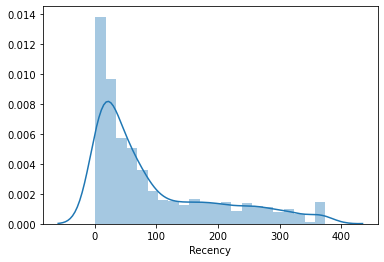

In [16]:
import seaborn as sns 
from matplotlib import pyplot as plt

sns.distplot(datamart['Recency'])
plt.show()

### Frequency - Right Skewed

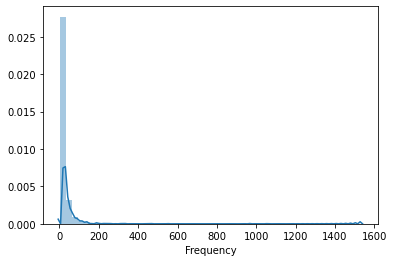

In [17]:
sns.distplot(datamart['Frequency'])
plt.show()

### Monetary Value - Right Skewed

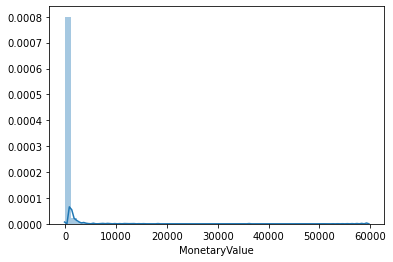

In [19]:
sns.distplot(datamart['MonetaryValue'])
plt.show()

### Skewness 조정 - Logarithmic transformation

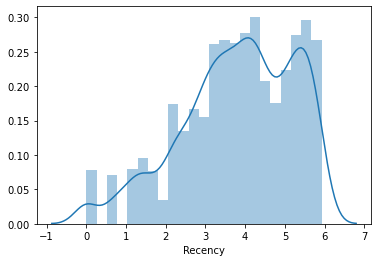

In [23]:
import numpy as np

recency_log= np.log(datamart['Recency'])
sns.distplot(recency_log)
plt.show()

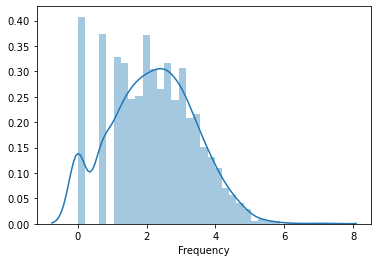

In [24]:
import numpy as np

frequency_log= np.log(datamart['Frequency'])
sns.distplot(frequency_log)
plt.show()

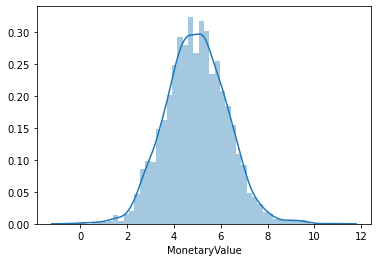

In [25]:
import numpy as np

monetary_log= np.log(datamart['MonetaryValue'])
sns.distplot(monetary_log)
plt.show()

## 군집화를 위한 전처리 2 - Centering and scaling variables

In [27]:
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,3701.000000,3701.000000,3701.000000,3701.000000
mean,94.298568,19.147257,380.535069,7.443394
std,99.974969,44.831615,1474.285937,2.825434
min,1.000000,1.000000,0.650000,3.000000
25%,19.000000,4.000000,59.400000,5.000000
50%,52.000000,9.000000,140.300000,7.000000
75%,151.000000,21.000000,337.800000,10.000000
max,374.000000,1532.000000,59596.070000,12.000000


K-Means는 평균이 같고, 분산/표준편차가 같은 변수들에 적용하였을 때 성능이 잘 나옴. 따라서 StandardScaling을 적용하여 전처리함. 

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(datamart)
datamart_normalized = scaler.transform(datamart)
print('mean: ', datamart_normalized.mean(axis=0).round(2))
print('std: ', datamart_normalized.std(axis=0).round(2))

mean:  [-0.  0.  0.  0. -0.  0.  0. -0.]
std:  [1. 1. 1. 1. 1. 1. 1. 1.]


## 주의: 전처리할 때 순서 중요! 

1. Unskew the data - log transformation
2. Standardize to the same average values
3. Scale to the same standard deviation
4. Store as a separate array to be used for clustering

In [35]:
# Unskew the data
import numpy as np
datamart_log = np.log(datamart[['Recency', 'Frequency', 'MonetaryValue']])

# Normalize the variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(datamart_log)

# Store for clustering
datamart_normalized = scaler.transform(datamart_log)

In [36]:
datamart_normalized

array([[-2.19564198,  0.90952097,  1.48288174],
       [-2.68455336,  3.84505048,  3.02243314],
       [-1.7067306 ,  1.16799951,  1.33138958],
       ...,
       [-1.21781921, -1.22561047, -1.15998279],
       [-1.7067306 ,  2.3271315 ,  0.85189033],
       [-0.03159076,  0.4273268 ,  0.78364369]])

## K-Means 군집화 

In [50]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=1)

kmeans.fit(datamart_normalized)

cluster_labels = kmeans.labels_

In [51]:
# 클러스터 레이블을 데이터프레임에 Cluster 컬럼으로 추가
datamart_rfm_k2 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k2

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Cluster
CustomerID,,,,,,,,,
12747,2,27,992.82,4,4,4,444,12,1
12748,1,967,7522.06,4,4,4,444,12,1
12749,4,37,813.45,4,4,4,444,12,1
12820,3,17,268.02,4,3,3,433,10,1
12822,71,9,146.15,2,2,3,223,7,0
...,...,...,...,...,...,...,...,...,...
18280,278,2,38.70,1,1,1,111,3,0
18281,181,2,31.80,1,1,1,111,3,0
18282,8,2,30.70,4,1,1,411,6,0


In [52]:
datamart_rfm_k2.groupby(['Cluster']).agg({'Recency': 'mean',
                                          'Frequency': 'mean',
                                          'MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         145.0       5.0          92.0  2029
1          33.0      36.0         731.0  1672

군집 0은 RFM 스코어가 낮고, 군집 1은 FRM 스코어가 높고. 단순한 군집화가 이루어짐

## 군집 개수 정하기 - Elbow Method

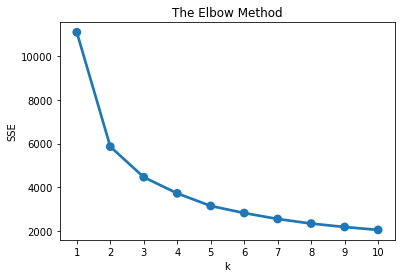

In [43]:
from sklearn.cluster import KMeans
import seaborn as sns
from matplotlib import pyplot as plt

# sse = sum of squanred distances to closes cluster center 
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_

plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [44]:
kmeans = KMeans(n_clusters=3, random_state=1)

kmeans.fit(datamart_normalized)

cluster_labels = kmeans.labels_

In [48]:
# 클러스터 레이블을 데이터프레임에 Cluster 컬럼으로 추가
datamart_rfm_k3 = datamart.assign(Cluster = cluster_labels)
datamart_rfm_k3

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,Cluster
CustomerID,,,,,,,,,
12747,2,27,992.82,4,4,4,444,12,0
12748,1,967,7522.06,4,4,4,444,12,0
12749,4,37,813.45,4,4,4,444,12,0
12820,3,17,268.02,4,3,3,433,10,0
12822,71,9,146.15,2,2,3,223,7,2
...,...,...,...,...,...,...,...,...,...
18280,278,2,38.70,1,1,1,111,3,1
18281,181,2,31.80,1,1,1,111,3,1
18282,8,2,30.70,4,1,1,411,6,1


In [49]:
datamart_rfm_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                          'Frequency': 'mean',
                                          'MonetaryValue': ['mean','count'],}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          14.0      53.0        1128.0   855
1         172.0       3.0          55.0  1224
2          78.0      14.0         232.0  1622

In [57]:
print(datamart_normalized.shape)
print(datamart)

(3701, 3)
            Recency  Frequency  MonetaryValue  R  F  M RFM_Segment  RFM_Score
CustomerID                                                                   
12747             2         27         992.82  4  4  4         444         12
12748             1        967        7522.06  4  4  4         444         12
12749             4         37         813.45  4  4  4         444         12
12820             3         17         268.02  4  3  3         433         10
12822            71          9         146.15  2  2  3         223          7
...             ...        ...            ... .. .. ..         ...        ...
18280           278          2          38.70  1  1  1         111          3
18281           181          2          31.80  1  1  1         111          3
18282             8          2          30.70  4  1  1         411          6
18283             4        152         432.93  4  4  4         444         12
18287            43         15         395.76  3  3  4

## 군집화 결과 해석하기 - 고객 프로파일링(Snake Plot 그리기)

In [58]:
datamart_rfm = datamart[['Recency', 'Frequency', 'MonetaryValue']]

In [60]:
datamart_normalized = pd.DataFrame(datamart_normalized,index=datamart_rfm.index, columns=datamart_rfm.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']

datamart_normalized

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12747,-2.195642,0.909521,1.482882,0
12748,-2.684553,3.845050,3.022433,0
12749,-1.706731,1.168000,1.331390,0
12820,-1.909647,0.530005,0.487337,0
12822,0.322128,0.008268,0.026297,2
...,...,...,...,...
18280,1.284889,-1.225610,-0.983925,1
18281,0.982207,-1.225610,-1.133219,1
18282,-1.217819,-1.225610,-1.159983,1


In [61]:
datamart_melt = pd.melt(datamart_normalized.reset_index(), id_vars=['CustomerID','Cluster'],
                        value_vars=['Recency','Frequency','MonetaryValue'],
                        var_name='Attribute',
                        value_name='Value')

datamart_melt

,CustomerID,Cluster,Attribute,Value
0,12747,0,Recency,-2.195642
1,12748,0,Recency,-2.684553
2,12749,0,Recency,-1.706731
3,12820,0,Recency,-1.909647
4,12822,2,Recency,0.322128
...,...,...,...,...
11098,18280,1,MonetaryValue,-0.983925
11099,18281,1,MonetaryValue,-1.133219
11100,18282,1,MonetaryValue,-1.159983
11101,18283,0,MonetaryValue,0.851890


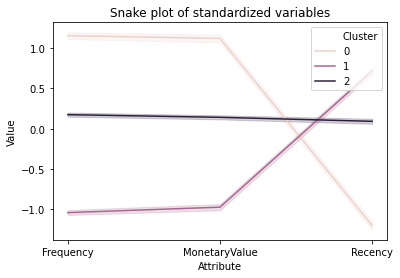

In [62]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=datamart_melt)

## 군집화 결과 해석하기 - 군집 Attribute의 상대적 중요성 파악하기

In [63]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart_rfm.mean()
relative_imp = cluster_avg / population_avg - 1

In [64]:
relative_imp.round(2)

,Frequency,MonetaryValue,RFM_Score,Recency
Cluster,,,,
0,1.75,1.96,NaN,-0.85
1,-0.84,-0.85,NaN,0.82
2,-0.29,-0.39,NaN,-0.17


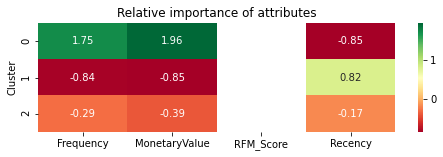

In [65]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()